Classification Resnet50

In [2]:
#conda env ryzenai1.3 test ok
#
import cv2
import numpy as np
import onnxruntime as ort
from matplotlib import pyplot as plt
import os
# 获取当前可用的 Execution Providers
available_providers = ort.get_available_providers()

print("Available Execution Providers:")
print(available_providers)

os.environ["HSA_OVERRIDE_GFX_VERSION"] = "11.0.0"

Available Execution Providers:
['MIGraphXExecutionProvider', 'ROCMExecutionProvider', 'CPUExecutionProvider']


In [3]:

model = "toturials_models/resnet50/ResNet_int.onnx"

session = ort.InferenceSession(model, providers=['ROCMExecutionProvider'])


In [4]:
def preprocess_image(image_path):
    # 加载图像并调整大小
    img = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 转为 RGB
    img = cv2.resize(rgb_img, (224, 224))  # 调整为 224x224
    
    # 转换为 float32 类型，并归一化到 [0, 1]
    img = img.astype(np.float32) / 255.0
    
    # 标准化
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img = (img - mean) / std
    
    # 调整通道顺序为 [C, H, W]，再扩展为 [1, C, H, W],匹配模型输入
    #img = np.transpose(img, (2, 0, 1))  # 转换为 [C, H, W]
    img = np.expand_dims(img, axis=0)  # 转换为 [1, C, H, W]
    
    return rgb_img, img

Input tensor name: ResNet::input_0


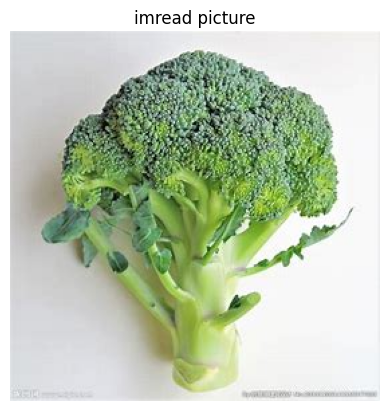

In [5]:
# 加载并预处理图像
image_path = r"temp/broccoli.jpg"  # 替换为您的测试图像路径

rgb_img, input_tensor = preprocess_image(image_path)
plt.imshow(rgb_img)
plt.axis("off")  # 隐藏坐标轴
plt.title("imread picture")
# 获取模型输入名称
input_name = session.get_inputs()[0].name
print(f"Input tensor name: {input_name}")


In [6]:
output = session.run(None, {input_name: input_tensor})[0]

KeyboardInterrupt: 

In [ ]:


# 定义 Softmax 函数（将 logits 转换为概率）
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # 为了数值稳定性，减去最大值
    return exp_x / np.sum(exp_x)

# 将 logits 转换为概率分布
probabilities = softmax(output[0])

# 加载类别标签
file_path = r"toturials_models/resnet50/resnet50_clsidx_to_labels.names"  # 替换为实际文件路径
with open(file_path, "r") as f:
    class_names = [line.strip() for line in f.readlines()]  # 去掉换行符

# 提取前 5 个类别及其概率
top_5_indices = np.argsort(probabilities)[-5:][::-1]  # 从大到小排序，取前 5 个索引
top_5_probabilities = probabilities[top_5_indices]  # 获取对应的概率值

# 打印前 5 类别的名称和概率
print("Top 5 Predicted Classes:")
for i, (idx, prob) in enumerate(zip(top_5_indices, top_5_probabilities)):
    print(f"Rank {i + 1}: Class {class_names[idx]}, Probability {prob:.4f}")


In [ ]:


predicted_class_name = class_names[top_5_indices[0]]  # 获取最高类别名称
predicted_probability = top_5_probabilities[0]       # 获取最高类别的概率
# 在图片上添加预测结果
text = f"{predicted_class_name}: {predicted_probability:.2f}"



# 在 Jupyter Notebook 中显示图片
plt.imshow(rgb_img)
plt.axis("off")  # 隐藏坐标轴
plt.title(text)
plt.show()

